In [162]:
import gymnasium as gym
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import copy
import pickle

In [2]:
env = gym.make("CartPole-v1")

In [161]:
def make_model():
    inps = keras.Input(shape=(4))
    x = keras.layers.Dense(256, activation='relu')(inps)
    x = keras.layers.Dense(128, activation='relu')(x)
    outs = keras.layers.Dense(2, activation='linear')(x)
    model = keras.Model(inputs=inps, outputs=outs)
    return model

def running_mean(a, l=20):
    x = []
    for i in range(len(a)-l):
        x.append(sum(a[i:i+l])/l)
    return x

# Using ---> Q-Learning

In [218]:
model = make_model()

EPOCHS = 100
E = 0.005
GAMMA = 0.9
EP_LEN = 200
optim = tf.optimizers.RMSprop(learning_rate=0.01)

game_hist = []


for i in range(EPOCHS):
    t = 0
    done = False
    s1 = env.reset()[0]
#     if i%10:
#         E/=10
    while not done:
        t+=1
        q_val = model(np.array([s1]))[0]
        if random.random()<E:
            a = random.randint(0,1)
        else :
            a = np.argmax(q_val)
        
        a = int(a)
        s2, r, done, trunc , info = env.step(a)
        q_next = model(np.array([s2]))[0]
        q_next_max = q_next[tf.argmax(q_next)]
        y = q_val[a] + GAMMA*(q_next_max+EP_LEN*10)
        with tf.GradientTape() as tape:
            q_val_pred = model(np.array([s1]), training=True)
            x = tf.gather_nd(q_val_pred, [[i,j] for i,j in enumerate([a])])
            loss = -keras.losses.MSE(np.array([y]),x)
        grads = tape.gradient(loss, model.trainable_weights)
        optim.apply_gradients(zip(grads, model.trainable_weights))
        s1 = s2
        if t>EP_LEN : 
            break
    game_hist.append(t)

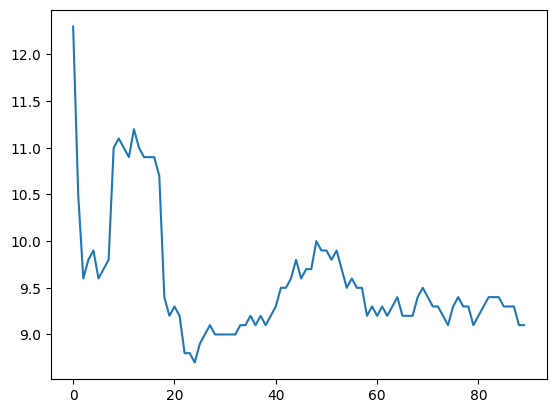

In [219]:
plt.plot(running_mean(game_hist, 10))

In [ ]:
# above approach is not working so trying it with replay memory.

In [198]:
model = make_model()

EPOCHS = 500
E = 0.005
GAMMA = 0.9
EP_LEN = 200
optim = tf.optimizers.RMSprop(learning_rate=0.01)

game_hist = []

for i in range(EPOCHS):
    t = 0
    replay = []
    done = False
    s1 = env.reset()[0]
#     if (i%10):
#         E/=10
    while not done:
        t+=1
        q_val = model(np.array([s1]))[0]
        if random.random()<E:
            a = random.randint(0,1)
        else :
            a = np.argmax(q_val)
        
        a = int(a)
        s2, r, done, trunc , info = env.step(a)
        q_next = model(np.array([s2]))[0]
        q_next_max = q_next[tf.argmax(q_next)]
        y =  q_val[a] + GAMMA*(q_next_max)
        
        x = tf.gather_nd([q_val], [[i,j] for i,j in enumerate([a])])
        exp = [s1, a, x, y]
        replay.append(exp)
        
        if t>EP_LEN : 
            break
        s1 = s2
        
    
    s1_batch = [[s1] for s1, a, x, y in replay]
    a_batch = [a for s1, a, x, y in replay]
    y_batch = [y for s1, a, x, y in replay]

    with tf.GradientTape() as tape:
        q_val_pred = model(np.squeeze(s1_batch,1), training=True)
        x = tf.gather_nd(q_val_pred, [[i,j] for i,j in enumerate(a_batch)])
#         print(x , y_batch , a_batch)
        loss = -keras.losses.MSE(np.array(y_batch),x)
    grads = tape.gradient(loss, model.trainable_weights)
    optim.apply_gradients(zip(grads, model.trainable_weights))
    
        
    game_hist.append(t)

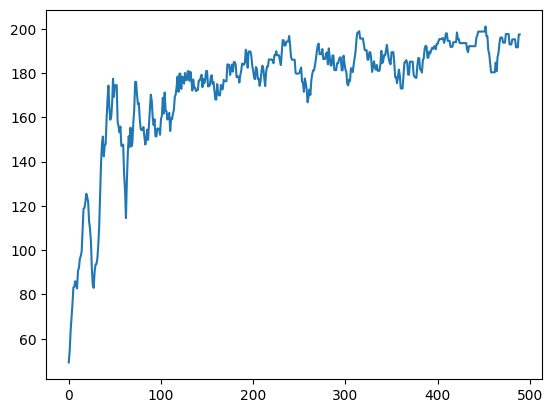

In [199]:
plt.plot(running_mean(game_hist, 10))

In [200]:
replay_model = copy.deepcopy(model)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......input_layer
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-03-01 02:08:14       150992
metadata.json                                  2023-03-01 02:08:14           64
config.json                                    2023-03-01 02:08:14         1922
Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-03-01 02:08:14       150992
metadata.json                                  2023-03-01 02:08:14           64
config.json                                    2023-03-01 02:08:14         1922
Keras weights file (<

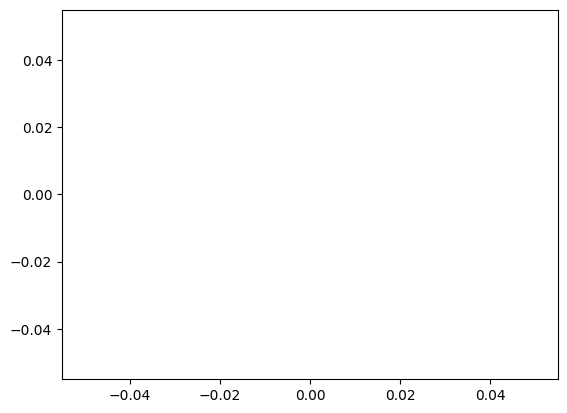

In [209]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
games = 1
game_t = 200
result = []
for i in range(games):
    s = env.reset()[0]
    for t in range(game_t):
        a = np.argmax(replay_model(np.array([s]))[0])
        s, r, d , _, __ = env.step(a)
        env.render()
        if d:
            break
    result.append(t)
plt.plot(running_mean(result, 10))

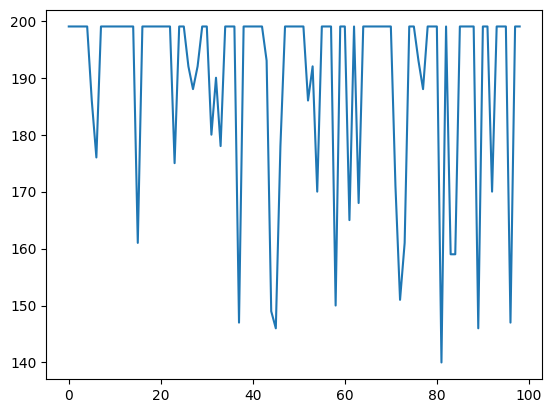

In [206]:
plt.plot(running_mean(result, 1))

In [207]:
# saving best model so far which is the model using replay_memory
f = open("Cartpole_model_replay_memory.keras", 'wb')
pickle.dump(replay_model, f)
f.close()

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......input_layer
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-03-01 02:10:58       150992
metadata.json                                  2023-03-01 02:10:58           64
config.json                                    2023-03-01 02:10:58         1922
